In [13]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import math as maths
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from scipy.integrate import odeint
from scipy.optimize import minimize as minimise, curve_fit

sns.set(style="white", color_codes=True)
sns.despine(trim = True)
sns.set_context('poster', font_scale = 1)
sns.set_palette("colorblind") #sns colormap for graph


# Testing 6 Parameter Sensitivity
- tests model output when parameters are varied by a given percentage

In [14]:
int_params = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1] #initial parameter guess to feed into minimiser function
timespan = np.linspace(0,72,100) #time span for simulation
time = [0, 24, 48, 72] #time points of each data point
sigma = [100, 0.00001, 0.00001, 0.00001]


file_name = 'cell_population_counts_Col0_Mute_SPCH.xlsx'
dfAllCounts = pd.read_excel(open(file_name,'rb'), sheetname='test counts') #make df from spreadsheet

In [15]:
def get_cell_counts(background, growth_condition):
    
    '''
    Function to extract array of cell type counts for each condition:
    CELLTYPES = [[counts at 0h][counts at 24h][counts at 48h][counts at 72h]]
    '''
    
    MCS_GMCS = [conditions_dict[background, growth_condition, t][0]+conditions_dict[background, growth_condition, t][1] for t in dfAllCounts.time.unique()]
    STMS = [conditions_dict[background, growth_condition, t][2] for t in dfAllCounts.time.unique()]
    SLGCS = [conditions_dict[background, growth_condition, t][3] for t in dfAllCounts.time.unique()]
    PCS = [conditions_dict[background, growth_condition, t][4] for t in dfAllCounts.time.unique()]
    
    return np.asarray([MCS_GMCS, STMS, SLGCS, PCS])

In [16]:
def diffeq(y, t, k0, k1, k2, k3, k4, k5):

    ''' 
    Function containing the ODEs for the model system:
    inputs:
        y - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t - time over which the function runs (not necessary for the equation, but is for integration with odeint)
        k0, k1, k2, k3, k4, k5, k6 - float, parameter values
    '''

    SPCi = y[0]
    STMi = y[1]
    SLGCi = y[2]
    PCi = y[3]
    #the model equations =

    f0 = (k3*SLGCi) - ((k0+k1)*SPCi)
    f1 = (k0*SPCi)
    f2 = (k1*SPCi)+(k4*PCi)-((k2+k3)*SLGCi)
    f3 = (k2*SLGCi) + ((k5-k4)*PCi)

    return [f0, f1, f2, f3]

In [17]:
def diffeqsolver(y1, t1, parameters1):

    '''
    function which passes the input from func to odeint
    inputs:
        y1 - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t1 - time for diffeq solver
        parameters - list of parameters to be fed to diffeqs
    '''

    parameters_tuple = tuple(parameters1)

    soln = odeint(diffeq, y1, t1, args = parameters_tuple)
    MC = soln[:, 0]
    STM = soln[:, 1]
    SLGC = soln[:, 2]
    PC = soln[:, 3]

    return [MC, STM, SLGC, PC]


In [18]:
def param_fitter(cell_counts, initial_guess):
    '''
    function to pass data through scipy.minimize (here named minimise)
    input:
        - cell counts at t0
        - initial guess of parameter values
        
    output:
        - scipy.minimise object attribute .x, which is the minimised parameter values.
    '''
    initial_guess = initial_guess
    def minimiserk7(params1):

        '''function to be minimised by the scipy minimiser.
        accepts only params, an array of the first guesses for each parameter.

        outputs the regression for the fit between a line of best fit and the model.'''

        xlist = cell_counts #cell type to be fitted to
        y1 = xlist[:,0]

        y = diffeqsolver(y1, timespan, params1)
        minval = np.zeros(len(xlist))  
        for x in range(len(xlist)):
            
            curve = np.polyfit([0, 24, 48, 72],xlist[x], 1, w = sigma) #fit cell counts from data to a curve for linregress

            x2 = np.polyval(curve, timespan) #evaluate curve over timecourse

            y0 = y[x] #values from integrated ode over time

            ss=lambda data,model:((data-model)**2).sum()
            minval[x] = ss(x2, y0)
            
        return minval.sum()
    
    solution = minimise(minimiserk7, initial_guess, bounds = 
                        ((0, None),(0, None),(0, None),(0, None),(0, None), (0, None)))
    

    return solution.x

In [19]:
def sensitivity_analysis(diff_eq, parameters, timespan, change_val, y_int, file_name):
    '''
    varies the parameter values to a given percentage value, outputs series of graphs for each parameter
    input:
    - diff_eq: function containing system of differential equations that describe model
    - parameters: np array of parameter values for system
    - timespan: np array of timepoints over which to run the simulation
    - change_val: percentage to vary the parameter values over
    - file_name: filename to save graph produced to
    '''

    fig= plt.figure(figsize=(16,12))
    ncols = 3
    nrows = maths.ceil((len(parameters)+1)/ ncols)
    i = 1
    for x in range(len(parameters)):
        '''find max, min and midpoint values for model outputs when varying the value of each parameter in turn'''
        k = parameters[x]
        
        if k == 0:
            continue
        else:
            
            minval = k*(1-change_val)
            maxval = k*(1+change_val)
            axs = fig.add_subplot(nrows, ncols, i)


            midsoln = odeint(diff_eq, y_int, timespan, args = tuple(parameters)) #solve odes using fitted parameter value to find midpoint

            np.put(parameters, x, minval)
            minsoln = odeint(diff_eq, y_int, timespan, args = tuple(parameters)) #solve odes using param value - given percent for minimum value

            np.put(parameters, x, maxval)
            maxsoln = odeint(diff_eq, y_int, timespan, args = tuple(parameters)) #solve odes using param value + given percent for maximum value
            np.put(parameters, x, k)
            solns = [[maxsoln[:, i], midsoln[:, i], minsoln[:, i]] for i in range(len(maxsoln[0,:]))]

            for n in range(0, len(maxsoln[0,:])):
                '''plot each model output with fill_between showing the minimum-maximum range.'''
                graphs = solns[n]
                axs.fill_between(timespan, graphs[2], graphs[0], alpha = 0.5, color = 'gray')
                axs.plot(timespan, graphs[1])
            axs.set_xlim(0, 72)
            axs.set_ylim(0, 0.8)
            axs.set_title('k'+str(x)+' +/- '+str(change_val*100)+'%', fontsize = 20)
            i += 1
        sns.despine()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(file_name)
    

## Sensitivity analysis for k values

Previous fitting work has shown that the extra k value is not necessary, so now a sensitivity analysis will be carried out. This is to test the sensitivity of the system to change, and the potential k values for a mutant population.

![](k7_fittingCol0est.svg)

In [20]:
conditions_dict = {}  

for b,i,t in list(itertools.product(dfAllCounts.background.unique(), 
                                    dfAllCounts.growth_condition.unique(),
                                    dfAllCounts.time.unique())):
    
    conditionPD = dfAllCounts[(dfAllCounts.background == b)&(dfAllCounts.time == t)
                                           &(dfAllCounts.growth_condition == i)]
    
    avgarea = np.nanmean(conditionPD.avg_cell_area)
    
    conditions_dict[b,i,t]=[(np.nanmean(conditionPD.MC)*avgarea),
                        (np.nanmean(conditionPD.GMC)* avgarea),
                        (np.nanmean(conditionPD.Stomata)* avgarea),
                        (np.nanmean(conditionPD.SLGC)* avgarea),
                        (np.nanmean(conditionPD.PC)* avgarea)]


cell_counts = get_cell_counts('Col0', 'mock')
int_params = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
cell_counts[:, 0]
fitted_params = param_fitter(cell_counts, int_params)

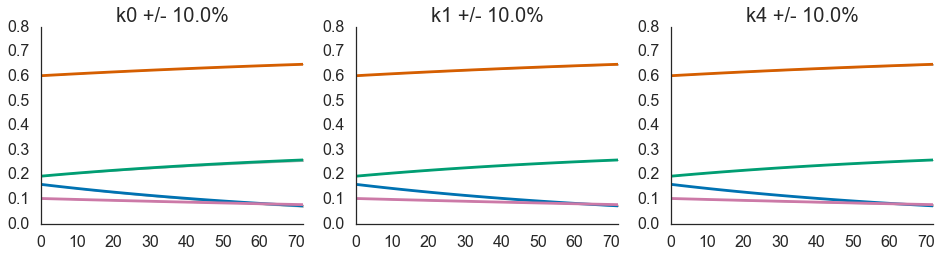

In [21]:
percentchange = 0.1

sensitivity_analysis(diffeq, fitted_params, timespan, percentchange, cell_counts[:,0], 'NEW_sensitivity_analysis_10_percent.svg')

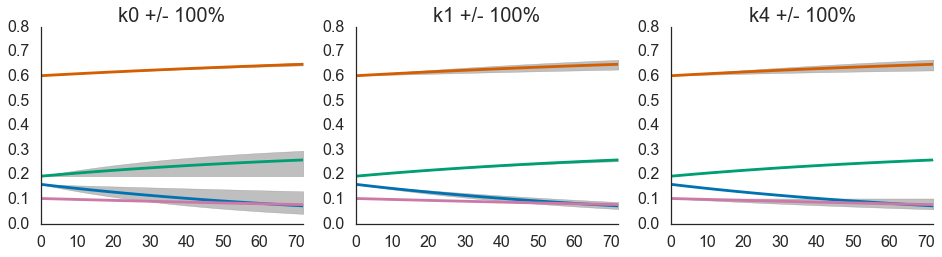

In [22]:
percentchange = 1

sensitivity_analysis(diffeq, fitted_params, timespan, percentchange, cell_counts[:,0], 'NEW_sensitivity_analysis_90_percent.svg')

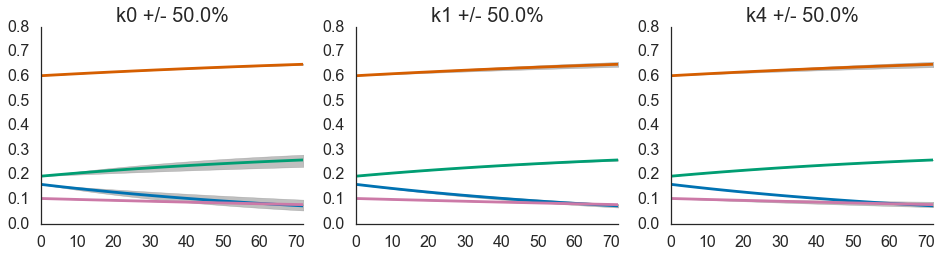

In [23]:
percentchange = 0.5

sensitivity_analysis(diffeq, fitted_params, timespan, percentchange, cell_counts[:,0], 'NEW_sensitivity_analysis_50_percent.svg')